# Create, store and query OpenAI embeddings in Azure SQL DB

This notebook will teach you to:

- How to create embeddings from content using the Azure OpenAI API
- How to use Azure SQL DB as a vector database and store embeddings data in SQL & perform similarity search
- How to use embeddings retrieved from a vector database to augment LLM generation.

In this tutorial we will be using the [Fine Foods Review Dataset](https:\www.kaggle.com\datasets\snap\amazon-fine-food-reviews) available on Kaggle. This dataset consists of reviews of fine foods from amazon

We will be using a [smaller sample](https://github.com/Azure-Samples/azure-sql-db-vector-search/blob/a181e15337402e568f4fc66fe5941e5973171972/VectorSearch_Notebooks/Datasets/Reviews.csv) for the tutorial. If you want to skip the steps of generating embeddings & directly load it in SQLDB to perform similarity search you can download the  [finefoodembeddings.csv](https:\github.com\Azure-Samples\azure-sql-db-vector-search\blob\a181e15337402e568f4fc66fe5941e5973171972\VectorSearch_Notebooks\Datasets\finefoodembeddings.csv)  file that contains generated embeddings using text-embedding-small model from Azure OpenAI.

This notebook contains some code snippets from the documentation [Explore Azure OpenAI Service embeddings Tutorial](https:\learn.microsoft.com\en-us\azure\ai-services\openai\tutorials\embeddings?tabs=python-new%2Ccommand-line&pivots=programming-language-python)

## Prerequisites:

- An Azure subscription - [Create one for free](https:\azure.microsoft.com\free\cognitive-services?azure-portal=true)
    
- Azure SQL Database - [Create one for free](https:\learn.microsoft.com\azure\azure-sql\database\free-offer?view=azuresql)
    
- [Azure Data Studio](https://azure.microsoft.com/products/data-studio)  to connect to an Azure SQL database & [run the notebook.](https://learn.microsoft.com/en-us/azure-data-studio/notebooks/notebooks-python-kernel)
    

### If you want to generate embeddings on your own & use the chatbot then you will also need

- Access granted to Azure OpenAI in the desired Azure subscription. Currently, access to this service is granted only by application. You can apply for access to Azure OpenAI by completing the form at [https://aka.ms/oai/access](https:\aka.ms\oai\access). Open an issue on this repo to contact us if you have an issue.
    
- An Azure OpenAI resource with the [embeddings model](https:\learn.microsoft.com\en-us\azure\ai-services\openai\concepts\models#embeddings-models) like text-embedding-ada-002 or text-embedding-small model. A GPT3.5 model deployed for the [chatcompletion model](https:\learn.microsoft.com\en-us\azure\ai-services\openai\concepts\models#gpt-35-models). If you don't have a resource the process of creating one is documented in our [resource deployment guide](https:\learn.microsoft.com\en-us\azure\ai-services\openai\how-to\create-resource).
    
- [Python 3.7.1 or later version](https:\www.python.org)
    
- The following Python libraries: openai, num2words, matplotlib, plotly, scipy, scikit-learn, pandas, tiktoken , pyodbc 
    
- [Jupyter Notebooks](https:\learn.microsoft.com\en-us\azure-data-studio\notebooks\notebooks-guidance) ( If you have the Azure Data Studio can be used within that)

## Before we start you ensure you:

### **1\. Create the table in the database**

SQL commands are in the [createtable.sql](https:\github.com\Azure-Samples\azure-sql-db-vector-search\blob\5314865140dbcb22df8d0d1a8497788f7a5477bc\VectorSearch_Notebooks\Python_Notebook_Example\createtable.sql) script

### **2\. Fill out the .env file with your SQL server and Azure Open AI key and Endpoint values**

Make sure you can access OpenAI service by following the documentation here: [How do I get access to Azure OpenAI?](https://learn.microsoft.com/azure/ai-services/openai/overview#how-do-i-get-access-to-azure-openai).

Then retrieve the **Azure OpenAI _endpoint_ and _key_**:

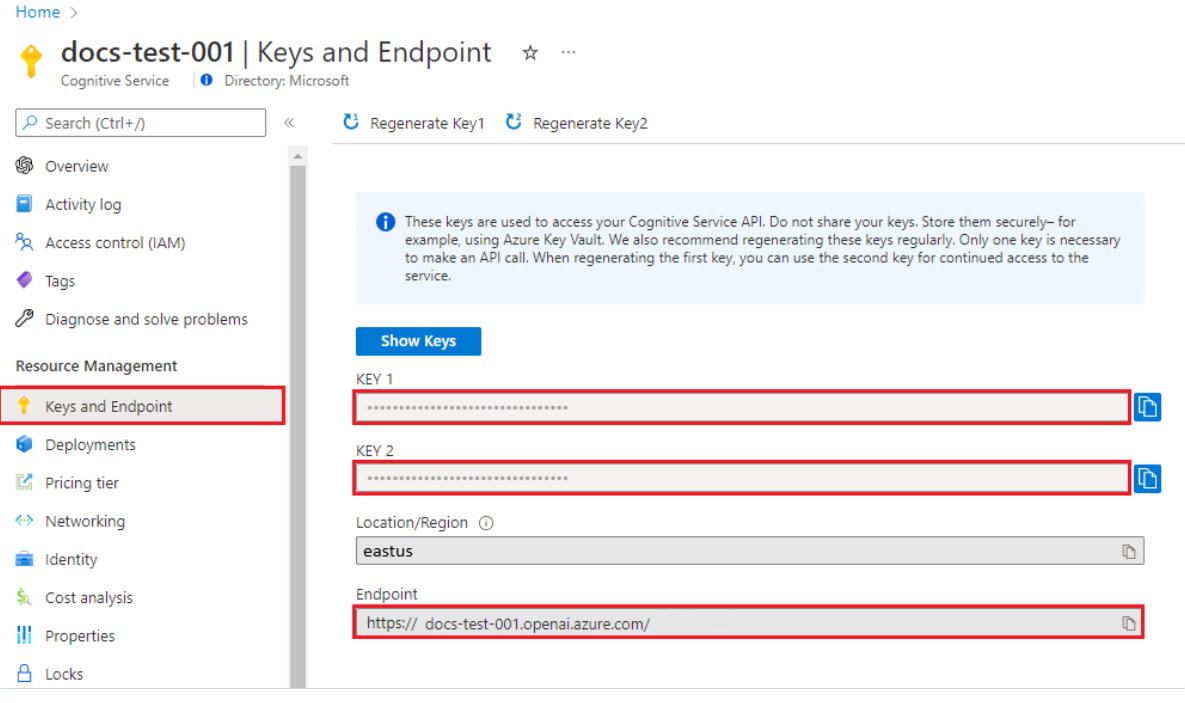

Deploy the embedding model - for example the text-embedding-small for embedding and a **GPT3.5 or GPT4** model for chatcompletion.  
**Note down the Model Deployment names** as you will need it later 

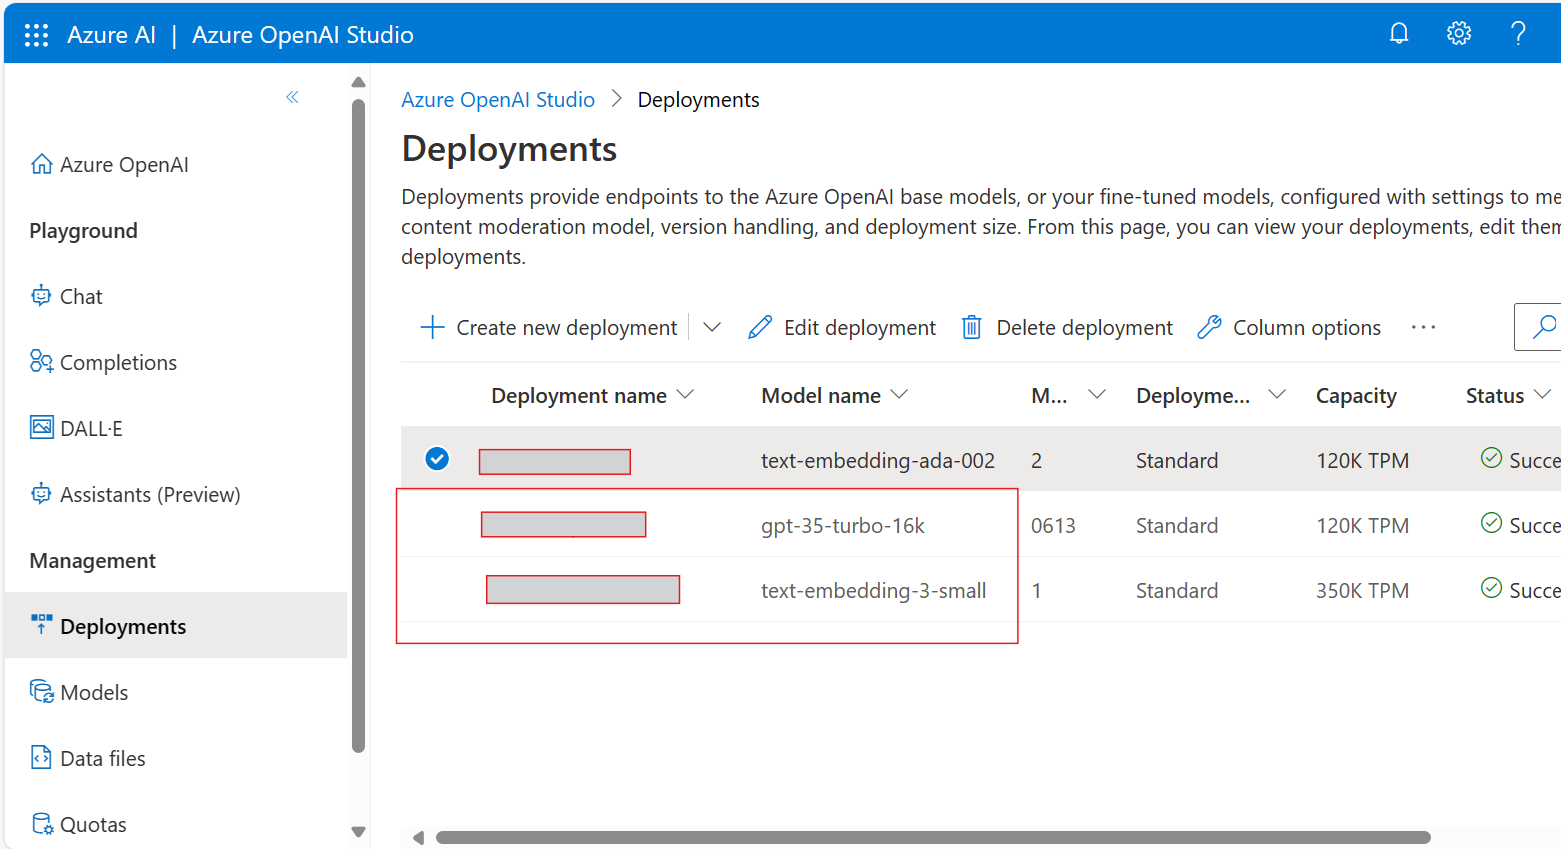

### **Azure SQL DB Connection String**

For Azure SQL Connection String details-  Navigate to the database pane in the Azure portal and, under Settings, select Connection strings

### **Running the Notebook**

You can download the [Azure Data Studio](https:\azure.microsoft.com\products\data-studio)   to connect to an Azure SQL database & [run the notebook.](https://learn.microsoft.com/en-us/azure-data-studio/notebooks/notebooks-python-kernel)

# Part 1 - Create embeddings from content using the Azure OpenAI API

Note: If you want to skip the steps of generating embeddings & directly load it in SQLDB to perform similarity search you can directly skip to Part 2) Load and Store embeddings in Azure SQL DB

In [ ]:
#Setup the python libraries required for this notebook
#Please ensure that you navigate to the directory containing the `requirements.txt` file in your terminal
pip install -r requirements.txt

In [9]:
#Load the env details
from dotenv import load_dotenv
load_dotenv()



True

Lets define the function to generate embeddings from Azure Open AI text-embedding-small model.

An embedding is a special format of data representation that can be easily utilized by machine learning models and algorithms. The embedding is an information dense representation of the semantic meaning of a piece of text.

Each embedding is a vector of floating point numbers, such that the distance between two embeddings in the vector space is correlated with semantic similarity between two inputs in the original format. For example, if two texts are similar, then their vector representations should also be similar. Embeddings power vector similarity search in Azure SQL Database

In [10]:
import os
import requests
import sys
from num2words import num2words
import pandas as pd
import numpy as np
import tiktoken
from openai import AzureOpenAI

# Assuming openai_url and openai_key are environment variables
openai_url = os.environ.get('openai_url')
openai_key = os.environ.get('openai_key')

def get_embedding(text):
    """
    Get sentence embedding using the Azure OpenAI text-embedding-small model.

    Args:
        text (str): Text to embed.

    Returns:
        dict: A dictionary containing the embedding.
    """
    response = requests.post(openai_url,
        headers={"api-key": openai_key, "Content-Type": "application/json"},
        json={"input": [text]}  # Embed a single sentence
    )
    embedding = response.json()['data'][0]['embedding']
    return embedding

In this tutorial we will be using the Fine Foods Review Dataset. This dataset consists of reviews of fine foods from Amazon.

Now we need to read our [Reviews.csv](https:\github.com\Azure-Samples\azure-sql-db-vector-search\blob\a181e15337402e568f4fc66fe5941e5973171972\VectorSearch_Notebooks\Datasets\Reviews.csv) file and create a pandas DataFrame. After the initial DataFrame is created, we can view the contents of the table by running the below. For the purpose of the quick embedding generation tutorial we will only use nrows = 500.

In [9]:
import pandas as pd

# load & inspect dataset
df = pd.read_csv(r"AzureSQLVectorSearch\Dataset\Reviews.csv" , nrows =500)
df = df[["Id" , "Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(10)

,Id,Time,ProductId,UserId,Score,Summary,Text,combined
0,1,1303862400,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Title: Good Quality Dog Food; Content: I have ...
1,2,1346976000,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Title: Not as Advertised; Content: Product arr...
2,3,1219017600,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all",This is a confection that has been around a fe...,"Title: ""Delight"" says it all; Content: This is..."
3,4,1307923200,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine,If you are looking for the secret ingredient i...,Title: Cough Medicine; Content: If you are loo...
4,5,1350777600,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy,Great taffy at a great price. There was a wid...,Title: Great taffy; Content: Great taffy at a ...
5,6,1342051200,B006K2ZZ7K,ADT0SRK1MGOEU,4,Nice Taffy,I got a wild hair for taffy and ordered this f...,Title: Nice Taffy; Content: I got a wild hair ...
6,7,1340150400,B006K2ZZ7K,A1SP2KVKFXXRU1,5,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,Title: Great! Just as good as the expensive b...
7,8,1336003200,B006K2ZZ7K,A3JRGQVEQN31IQ,5,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,"Title: Wonderful, tasty taffy; Content: This t..."
8,9,1322006400,B000E7L2R4,A1MZYO9TZK0BBI,5,Yay Barley,Right now I'm mostly just sprouting this so my...,Title: Yay Barley; Content: Right now I'm most...
9,10,1351209600,B00171APVA,A21BT40VZCCYT4,5,Healthy Dog Food,This is a very healthy dog food. Good for thei...,Title: Healthy Dog Food; Content: This is a ve...


Next we'll perform some light data cleaning by removing redundant whitespace and cleaning up the punctuation to prepare the data for tokenization. We will also remove comments that are too long for the token limit (8192 tokens)

In [10]:
import pandas as pd
import re
import tiktoken
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
# Assuming you have already loaded your DataFrame 'df'

# Remove null values
df.dropna(subset=['combined'], inplace=True)

# Convert to lowercase
df['combined'] = df['combined'].str.lower()

# Remove accented letters
df['combined'] = df['combined'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove punctuation marks
translator = str.maketrans('', '', string.punctuation)
df['combined'] = df['combined'].apply(lambda x: x.translate(translator))

# Remove redundant white space
df['combined'] = df['combined'].str.strip()

# Remove stopwords using NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['combined'] = df['combined'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Remove Unicode characters (like emojis)
df['combined'] = df['combined'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Tokenize using tiktoken
# Assuming you have already imported tiktoken and loaded the tokenizer
tokenizer = tiktoken.get_encoding("cl100k_base")
# Convert the list of tokens to a single integer (assuming each list contains token IDs)
df['n_tokens'] = df['combined'].apply(lambda x: len(tokenizer.encode(x)))
# Filter rows where 'n_tokens' is less than 8000
df = df[df['n_tokens'] < 8000]


# Print the modified DataFrame
print(df.head(2))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pookam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   Id        Time   ProductId          UserId  Score                Summary  \
0   1  1303862400  B001E4KFG0  A3SGXH7AUHU8GW      5  Good Quality Dog Food   
1   2  1346976000  B00813GRG4  A1D87F6ZCVE5NK      1      Not as Advertised   

                                                Text  \
0  I have bought several of the Vitality canned d...   
1  Product arrived labeled as Jumbo Salted Peanut...   

                                            combined  n_tokens  
0  title good quality dog food content bought sev...        32  
1  title advertised content product arrived label...        27  


The n\_tokens column is simply a way of making sure none of the data we pass to the model for tokenization and embedding exceeds the input token limit of 8,192. When we pass the comment to the embeddings model, it will break the comment into tokens similar (though not necessarily identical) to the examples above and then convert the tokens to a series of floating point numbers that will be accessible via vector search. These embeddings can be stored locally or in an [Azure SQL Database to support Vector Search.](https:\learn.microsoft.com\en-us\azure\azure-sql\database\ai-artificial-intelligence-intelligent-applications?view=azuresql)  

As a result, each **combined** (Product summary + Review) comment will have its own corresponding embedding vector in the new vector column on the right side of the DataFrame.

In [11]:
sample_encode = tokenizer.encode(df.combined[5]) 
decode = tokenizer.decode_tokens_bytes(sample_encode)
decode

[b'title',
 b' nice',
 b' t',
 b'aff',
 b'y',
 b' content',
 b' got',
 b' wild',
 b' hair',
 b' t',
 b'aff',
 b'y',
 b' ordered',
 b' five',
 b' pound',
 b' bag',
 b' t',
 b'aff',
 b'y',
 b' enjoyable',
 b' many',
 b' flavors',
 b' water',
 b'melon',
 b' root',
 b' beer',
 b' mel',
 b'on',
 b' pepp',
 b'ermint',
 b' grape',
 b' etc',
 b' complaint',
 b' bit',
 b' much',
 b' re',
 b'dbl',
 b'ack',
 b' lic',
 b'or',
 b'ice',
 b'fl',
 b'avored',
 b' pieces',
 b' particular',
 b' favorites',
 b' kids',
 b' husband',
 b' lasted',
 b' two',
 b' weeks',
 b' would',
 b' recommend',
 b' brand',
 b' t',
 b'aff',
 b'y',
 b' delightful',
 b' treat']

We will now **generate the embeddings** for the 'combined' column using the **get\_embeddings** function we had defined earlier.  
We now have an additional column in the dataframe called vector which has the embeddings.

This will take sometime depending on the Service Tier of Azure Open AI resource you have. For script with retry logic if you need to generate larger number of embeddings please refer to this example script

In [12]:
import pandas as pd

# Assuming you have a DataFrame 'df' with a 'combined' column
# and you want to apply 'get_embeddings' to each batch of 100 rows

batch_size = 100
num_batches = len(df) // batch_size

# Initialize an empty list to store the results
all_embeddings = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size

    # Get the current batch
    current_batch = df.iloc[start_idx:end_idx]

    # Apply your function to the 'combined' column
    batch_embeddings = current_batch['combined'].apply(get_embedding)

    # Append the batch results to the list
    all_embeddings.extend(batch_embeddings)
    print(f"Batch {i+1} completed. Processed {end_idx} rows.")

# Create a new column 'vector' with the combined embeddings
df['vector'] = all_embeddings

# Print the updated DataFrame
df.head(2)


Batch 1 completed. Processed 100 rows.


Batch 2 completed. Processed 200 rows.


Batch 3 completed. Processed 300 rows.


Batch 4 completed. Processed 400 rows.


Batch 5 completed. Processed 500 rows.


,Id,Time,ProductId,UserId,Score,Summary,Text,combined,n_tokens,vector
0,1,1303862400,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,title good quality dog food content bought sev...,32,"[0.02559923, -0.018715078, -0.02559923, -0.028..."
1,2,1346976000,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,title advertised content product arrived label...,27,"[0.0077655376, -0.01543994, -0.017482903, 0.01..."


# Part 2) Store & Query embeddings in Azure SQL DB.

## Before we begin, please determine which path you will be following for this part of the tutorial:

**Option A:** If you have completed Part 1 and generated embeddings using the Azure OpenAI API, you will insert the embeddings directly from the dataframe/generated output .

**Option B:** If you have not completed Part 1 or wish to use precalculated embeddings, you should download the [finefoodembeddings.csv](https:\github.com\azure-samples\azure-sql-db-vector-search\blob\a181e15337402e568f4fc66fe5941e5973171972\vectorsearch_notebooks\datasets\finefoodembeddings.csv\) file and we will use this to insert data into the SQL database.

Please follow the instructions corresponding to your chosen option.

## Connect to Azure SQL Database and load the data from the dataframe into a SQL Table

We will insert our vectors into the SQL Table now. The table embeddings has a column called vector which is varbinary(8000) type. Ensure you have created the table and index using the script [createtable.sql](https://github.com/Azure-Samples/azure-sql-db-vector-search/blob/bbe23e5908799fb940f8eb702a7666584c2dc4f3/VectorSearch_Notebooks/Python_Notebook_Example/createtable.sql)

We will pass the vectors to the new built in function **JSON\_ARRAY\_TO\_VECTOR** that will converts a JSON array to a compact **binary** representation of a vector.   Vectors are stored in an efficient binary format that also enables usage of dedicated CPU vector processing extensions like SIMD and AVX.           

On that table we can create a **column store index t**o efficiently store and search for vectors. Then it is just a matter of calculating the distance between vectors to find the closest. Thanks to the internal optimization of the columnstore (that uses SIMD AVX-512 instructions to speed up vector operations) the distance calculation to find the exact nearest neighbour search is extremely fast.

## `### Option A: Inserting Embeddings Generated in Part 1 into the SQL Table`

In [ ]:
import os
from dotenv import load_dotenv
import pyodbc
import struct
import json
from azure.identity import DefaultAzureCredential
 
# Load environment variables from .env file
load_dotenv()
 
# Retrieve the connection string from the environment variables
entra_connection_string = os.getenv('ENTRA_CONNECTION_STRING')
sql_connection_string = os.getenv('SQL_CONNECTION_STRING')
 
# Determine the authentication method and connect to the database
if entra_connection_string:
    # Entra ID Service Principle Authentication
    credential = DefaultAzureCredential()
    token = credential.get_token('https://database.windows.net/.default')
    token_bytes = token.token.encode('UTF-16LE')
    token_struct = struct.pack(f'<I{len(token_bytes)}s', len(token_bytes), token_bytes)
    SQL_COPT_SS_ACCESS_TOKEN = 1256  # This connection option is defined by Microsoft in msodbcsql.h
    conn = pyodbc.connect(entra_connection_string, attrs_before={SQL_COPT_SS_ACCESS_TOKEN: token_struct})
elif sql_connection_string:
    # SQL Authentication
    conn = pyodbc.connect(sql_connection_string)
else:
    raise ValueError("No valid connection string found in the environment variables.")
 
# Create a cursor object
cursor = conn.cursor()
 
# Enable fast_executemany
cursor.fast_executemany = True
 
# Loop through the DataFrame rows and insert them into the table
for index, row in df.iterrows():
    Id = row['Id']
    ProductId = row['ProductId']
    UserId = row['UserId']
    score = row['Score']
    summary = row['Summary']
    text = row['Text']
    combined = row['combined']
    vector = row['vector']
    # Use placeholders for the parameters in the SQL query
    query = """
    INSERT INTO embeddings (Id, ProductId, UserId, score, summary, text, combined, vector)
    VALUES (?, ?, ?, ?, ?, ?, ?, JSON_ARRAY_TO_VECTOR(CAST(? AS VARCHAR(MAX))))
    """
    # Execute the query with the parameters
    cursor.execute(query, Id, ProductId, UserId, score, summary, text, combined, json.dumps(vector))
 
# Commit the changes
conn.commit()
 
# Print a success message
print("Data inserted successfully into the 'embeddings' table.")
 
# Close the connection
conn.close()

## `### Option B: Inserting precalculated embeddings from the CSV file`

You can import this [finefoodembeddings.csv](https:\github.com\Azure-Samples\azure-sql-db-vector-search\blob\a181e15337402e568f4fc66fe5941e5973171972\VectorSearch_Notebooks\Datasets\finefoodembeddings.csv) with precalculated embeddings directly to your SQL table if you have not performed the above steps.

In [13]:
import pandas as pd

# load & inspect dataset
df = pd.read_csv(r"AzureSQLVectorSearch\Dataset\finefoodembeddings.csv")
df.head(2)

,Unnamed: 0,Id,Time,ProductId,UserId,Score,Summary,Text,combined,vector
0,0,1,1303862400,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Title: Good Quality Dog Food; Content: I have ...,"[0.02088439, -0.00022463033, -0.0019172364, -0..."
1,1,2,1346976000,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Title: Not as Advertised; Content: Product arr...,"[-0.0044591213, 0.00078397157, -0.022424141, 0..."


In [37]:
import os
from dotenv import load_dotenv
import pyodbc
import struct
from azure.identity import DefaultAzureCredential

# Load environment variables from .env file
load_dotenv()

# Retrieve the connection string from the environment variables
entra_connection_string = os.getenv('ENTRA_CONNECTION_STRING')
sql_connection_string = os.getenv('SQL_CONNECTION_STRING')

# Determine the authentication method and connect to the database
if entra_connection_string:
    # Entra ID Service Principle Authentication
    credential = DefaultAzureCredential()
    token = credential.get_token('https://database.windows.net/.default')
    token_bytes = token.token.encode('UTF-16LE')
    token_struct = struct.pack(f'<I{len(token_bytes)}s', len(token_bytes), token_bytes)
    SQL_COPT_SS_ACCESS_TOKEN = 1256  # This connection option is defined by Microsoft in msodbcsql.h
    conn = pyodbc.connect(entra_connection_string, attrs_before={SQL_COPT_SS_ACCESS_TOKEN: token_struct})
elif sql_connection_string:
    # SQL Authentication
    conn = pyodbc.connect(sql_connection_string)
else:
    raise ValueError("No valid connection string found in the environment variables.")

# Create a cursor object
cursor = conn.cursor()

# Enable fast_executemany
cursor.fast_executemany = True

# Assuming 'df' is your DataFrame and it's already defined
# Prepare your data to be inserted as a list of tuples
data_to_insert = [
    (
        row['Id'],
        row['ProductId'],
        row['UserId'],
        row['Score'],
        row['Summary'],
        row['Text'],
        row['combined'],
        row['vector']
    ) for index, row in df.iterrows()
]

# Define your SQL insert query. 
#We are using the JSON_ARRAY_TO_VECTOR function here which  converts the jsonarray to a compact binary representation of the vector
insert_query = """
INSERT INTO embeddings (Id, ProductId, UserId, score, summary, text, combined, vector)
VALUES (?, ?, ?, ?, ?, ?, ?, JSON_ARRAY_TO_VECTOR(CAST(? AS VARCHAR(MAX))))
"""

# Execute batch insert
cursor.executemany(insert_query, data_to_insert)

# Commit the transaction
conn.commit()

# Print a success message
print("Data inserted successfully into the 'embeddings' table.")

# Close the cursor and connection
cursor.close()
conn.close()


Data inserted successfully into the 'embeddings' table.


## Using the native vector functions in SQL DB

Lets take a look at how the vector is stored in the SQL DB table & also  <span style="color: var(--vscode-foreground);">&nbsp;make use of the newly introduced helper functions</span>

**ISVECTOR** Checks if the provided object is a valid vector: Returns 1 if valid, otherwise returns 0. Returns NULL if the expression is NULL

**VECTOR\_DIMENSIONS** Takes a vector as an input and returns the number of dimensions as an output. In this case we see the number of dimensions of the vector are 1536 (as we are using Azure OpenAI text embeddings)

**VECTOR\_TO\_JSON\_ARRAY** Converts a vector in a compact binary format to a human-readable string format. The string format is the same as the one used by JSON to represent arrays

In [45]:
from prettytable import PrettyTable

# Determine the authentication method and connect to the database
if entra_connection_string:
    # Entra ID Service Principle Authentication
    credential = DefaultAzureCredential()
    token = credential.get_token('https://database.windows.net/.default')
    token_bytes = token.token.encode('UTF-16LE')
    token_struct = struct.pack(f'<I{len(token_bytes)}s', len(token_bytes), token_bytes)
    SQL_COPT_SS_ACCESS_TOKEN = 1256  # This connection option is defined by Microsoft in msodbcsql.h
    conn = pyodbc.connect(entra_connection_string, attrs_before={SQL_COPT_SS_ACCESS_TOKEN: token_struct})
elif sql_connection_string:
    # SQL Authentication
    conn = pyodbc.connect(sql_connection_string)
else:
    raise ValueError("No valid connection string found in the environment variables.")

# Create a cursor object
cursor = conn.cursor()

# Use placeholders for the parameters in the SQL query
query = "SELECT TOP(10) ISVECTOR(vector) as isvector, VECTOR_DIMENSIONS(vector) as dimensions , summary , vector , VECTOR_TO_JSON_ARRAY(vector) as jsonvector,  ProductId FROM dbo.embeddings"

# Execute the query with the parameters
cursor.execute(query)
queryresults = cursor.fetchall()

# Get column names from cursor.description
column_names = [column[0] for column in cursor.description]

# Create a PrettyTable object
table = PrettyTable()

# Add column names to the table
table.field_names = column_names

# Set max width for each column to truncate data
table.max_width = 20

# Add rows to the table
for row in queryresults:
    # Truncate each value to 20 characters
    truncated_row = [str(value)[:20] for value in row]
    table.add_row(truncated_row)

# Print the table
print(table)

# Commit the changes
conn.commit()
# Close the connection
conn.close()


+----------+------------+----------------------+----------------------+----------------------+------------+
| isvector | dimensions |       summary        |        vector        |      jsonvector      | ProductId  |
+----------+------------+----------------------+----------------------+----------------------+------------+
|    1     |    1536    | Good Quality Dog Foo | b'\xa9\x01\x00\x06\x | [0.0208843909204006, | B001E4KFG0 |
|    1     |    1536    |  Not as Advertised   | b'\xa9\x01\x00\x06\x | [-0.0044591212645173 | B00813GRG4 |
|    1     |    1536    | "Delight" says it al | b'\xa9\x01\x00\x06\x | [0.0197708476334810, | B000LQOCH0 |
|    1     |    1536    |    Cough Medicine    | b'\xa9\x01\x00\x06\x | [-0.0131307244300842 | B000UA0QIQ |
|    1     |    1536    |     Great taffy      | b'\xa9\x01\x00\x06\x | [0.0057999598793685, | B006K2ZZ7K |
|    1     |    1536    |      Nice Taffy      | b'\xa9\x01\x00\x06\x | [0.0326173491775990, | B006K2ZZ7K |
|    1     |    1536    | Gr

## Performing Vector Similarity Search in Azure SQL DB

Lets now query our embedding table to get the top similar reviews given the _User search_ query.

What we are doing: Given any user search query, we can get the vector representation of that text.   

<span style="color: var(--vscode-foreground);">Then we can use that vector to calculate the cosine distance against all the customer review comments stored in the database and take only the closest ones which will return the product most likely connect to the product we are interested in. The reviews with the highest similarity are considered the most relevant to the query, helping users discover products or experiences related to their search.</span>

The most common distance is the cosine similarity, which can be calculated quite easily in SQL with the help of the new distance functions.

**VECTOR\_DISTANCE**( 'distance metric' , V1, V2)

<span style="color: var(--vscode-foreground);">We can use&nbsp;</span>  **cosine**  <span style="color: var(--vscode-foreground);">&nbsp;,&nbsp;</span>  **euclidean**  <span style="color: var(--vscode-foreground);">&nbsp;and&nbsp;</span>  **dot**  <span style="color: var(--vscode-foreground);">&nbsp;as the distance metric today</span>

We will define the function <span style="color: rgb(121, 94, 38); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">vector_search_sql</span>

In [11]:
import os
import json
from dotenv import load_dotenv
import pyodbc
import struct
from azure.identity import DefaultAzureCredential

def vector_search_sql(query, num_results=5):
    # Load environment variables from .env file
    load_dotenv()

    # Retrieve the connection string from the environment variables
    entra_connection_string = os.getenv('ENTRA_CONNECTION_STRING')
    sql_connection_string = os.getenv('SQL_CONNECTION_STRING')

    # Determine the authentication method and connect to the database
    if entra_connection_string:
        # Entra ID Service Principle Authentication
        credential = DefaultAzureCredential()
        token = credential.get_token('https://database.windows.net/.default')
        token_bytes = token.token.encode('UTF-16LE')
        token_struct = struct.pack(f'<I{len(token_bytes)}s', len(token_bytes), token_bytes)
        SQL_COPT_SS_ACCESS_TOKEN = 1256  # This connection option is defined by Microsoft in msodbcsql.h
        conn = pyodbc.connect(entra_connection_string, attrs_before={SQL_COPT_SS_ACCESS_TOKEN: token_struct})
    elif sql_connection_string:
        # SQL Authentication
        conn = pyodbc.connect(sql_connection_string)
    else:
        raise ValueError("No valid connection string found in the environment variables.")

    # Create a cursor object
    cursor = conn.cursor()

    # Generate the query embedding for the user's search query
    user_query_embedding = get_embedding(query)

    # Convert user_query_embedding to a JSON string
    user_query_embedding_json = json.dumps(user_query_embedding)

    # SQL query for similarity search using the function vector_distance to calculate cosine similarity
    sql_similarity_search = """
    SELECT TOP(?) ProductId, Summary, text,
           1 - vector_distance('cosine', JSON_ARRAY_TO_VECTOR(cast(? as varchar(max))), [vector]) AS similarity_score
    FROM dbo.embeddings
    ORDER BY similarity_score desc
    """

    cursor.execute(sql_similarity_search, (num_results, user_query_embedding_json))
    results = cursor.fetchall()

    # Close the database connection
    conn.close()

    return results


In [12]:
# Assuming you have implemented the `vector_search_sql` function as shown earlier

# Example usage
query = "oatmeal options for my toddler"
num_results = 4
search_results = vector_search_sql(query, num_results)
for result in search_results:
    product_id = result[0]  # Assuming ProductId is the first column
    summary = result [1]
    text = result [2]
    similarity_score = result[3]  # Assuming similarity_score is the third column
    
    print(f"Product ID: {product_id}")
    print(f"summary : {summary}")
    print (f"Text : {text}")
    print(f"Similarity Score: {similarity_score}\n")


Product ID: B001DIM8K8
summary : Nothing like the crappy stuff I grew up on.
Text : My daughter and I eat low-carb. Which oatmeal is not really, by the way. But I was looking for something that we could eat in the morning that was not meat/dairy/egg, and was gluten-free, and filling, without being pure sugar like most breakfast foods and especially grains. I decided to try these long-cooking irish oats. We use 2 cups water and 1/2 cup dry oats, for 1/4cup dry each. It takes this stuff 30 minutes+ to cook so it is not fast food, for sure. But strangely enough, it's filling. Adding fats (couple tablespoons of cream) to the serving helps that of course. In any case, it is much tastier, and much more long-lasting for keeping us satisfied, than I expected, and surprisingly stable on blood sugar. Nor has it set off cravings like most grains, fruits, etc. do if we eat those; the sugars digest so slowly in this apparently. It is more solid and nutty than the flakey quick-oats I grew up with, w

# Part 3 - Use embeddings retrieved from a vector database to augment LLM generation

Lets create a helper function to feed prompts into the [Completions model](https:\learn.microsoft.com\en-us\azure\ai-services\openai\concepts\models#gpt-35-models) & create interactive loop where you can pose questions to the model and receive information grounded in your data.

The function generate\_completion is defined to help ground the GPT3.5 model with prompts and system instructions.   
Note that we are passing the results of the vector\_search\_sql we defined earlier to the model and we define the system prompt .  
We are using gpt-35-turbo-16k model here. 

You can get more information on using Azure Open AI GPT chat models [here](https:\learn.microsoft.com\en-us\azure\ai-services\openai\chatgpt-quickstart?tabs=command-line%2Cpython-new&pivots=programming-language-python)

In [13]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI

# Load environment variables from .env file
load_dotenv()

# Retrieve the API key and endpoint from the environment variables
api_key = os.getenv('AZURE_OPENAI_API_KEY')
azure_endpoint = os.getenv('AZURE_OPENAI_ENDPOINT')

# Create a chat completion request
client = AzureOpenAI(
    api_key=api_key,
    api_version="2023-05-15",
    azure_endpoint=azure_endpoint
)


def generate_completion(search_results, user_input):
    system_prompt = '''
You are an intelligent & funny assistant who will exclusively answer based on the data provided in the `search_results`:
- Use the information from `search_results` to generate your responses. If the data is not a perfect match for the user's query, use your best judgment to provide helpful suggestions and include the following format:
  Product ID: {product_id}
  Summary: {summary}
  Review: {text}
  Similarity Score: {similarity_score}
- Avoid any other external data sources.
- Add a fun fact related to the overall product searched at the end of the recommendations.
'''

    messages = [{"role": "system", "content": system_prompt}]
    search_results = vector_search_sql(user_input, num_results)
    
    # Create an empty list to store the results
    result_list = []

    # Iterate through the search results and append relevant information to the list
    for result in search_results:
        product_id = result[0]  # Assuming ProductId is the first column
        summary = result[1]
        text = result[2]
        similarity_score = result[3]  # Assuming similarity_score is the third column
        
        # Append the relevant information as a dictionary to the result_list
        result_list.append({
            "product_id": product_id,
            "summary": summary,
            "text": text,
            "similarity_score": similarity_score
        })

    #print (result_list)
    messages.append({"role": "system", "content": f"{result_list}"})
    messages.append({"role": "user", "content": user_input})
    response = client.chat.completions.create(model='chatcompletion', messages=messages, temperature=0) #replace with your model deployment name

    return response.dict()

In [14]:
# Create a loop of user input and model output to perform Q&A on the FineFoods Sample data

print("*** What products are you looking for? Ask me & I can help you :) Type 'end' to end the session.\n")

while True:
    user_input = input("User prompt: ")
    if user_input.lower() == "end":
        break

    # Print the user's question
    print(f"\nUser asked: {user_input}")

    # Assuming vector_search_sql and generate_completion are defined functions that work correctly
    search_results = vector_search_sql(user_input)
    completions_results = generate_completion(search_results, user_input)

    # Print the model's response
    print("\nAI's response:")
    print(completions_results['choices'][0]['message']['content'])

# The loop will continue until the user types 'end'


*** What products are you looking for? Ask me & I can help you :) Type 'end' to end the session.




User asked: can you suggest some canned food for my cat. Mind you he is very fussy!



AI's response:
I have found some canned cat food options that have received positive reviews from cat owners with picky eaters like yours. Here are a few recommendations:

Product ID: B002OHOC6A
Summary: Cat food
Review: My cat's favorite cat food! He is very picky and will not eat a lot of different cat foods, but he loves this one.
Similarity Score: 0.623

Product ID: B003SE19UK
Summary: Palatable and healthy
Review: Before I was educated about feline nutrition, I allowed my cats to become addicted to dry cat food. I always offered both canned and dry, but wish I would have fed them premium quality canned food and limited dry food. I have two 15-year-old cats and two 5-year-old cats. The only good quality dry foods they will eat are Wellness and Innova. Innova's manufacturer was recently purchased by Procter&Gamble. I began looking for a replacement. After once again offering several samples (from my local holistic pet store) Holistic Select was the only one (other than the usual We

## You can use also use Semantic Search with Keyword search (Hybrid) in SQL DB along with using filters and aggregations . Check out the [TSQL samples](https:\github.com\Azure-Samples\azure-sql-db-vector-search\blob\bbe23e5908799fb940f8eb702a7666584c2dc4f3\VectorSearch_Notebooks\SQL_Notebook_Example\SQLvectorsimilaritysearch.sql)